In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import warnings; warnings.simplefilter('ignore')

In [113]:
# Get Data from /Data
qb_combine = pd.read_csv("Data/QB_combine_data.csv")
rb_combine = pd.read_csv("Data/RB_combine_data.csv")
wr_combine = pd.read_csv("Data/WR_combine_data.csv")
te_combine = pd.read_csv("Data/TE_combine_data.csv")

qb_bdays = pd.read_csv("Data/qb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
rb_bdays = pd.read_csv("Data/rb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
wr_bdays = pd.read_csv("Data/wr_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
te_bdays = pd.read_csv("Data/te_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')

qb_stats = pd.read_csv("Data/qbdata.csv", thousands=',')
rb_stats = pd.read_csv("Data/rbdata_rush.csv", thousands=',')
wr_stats = pd.read_csv("Data/wrdata.csv", thousands=',')
te_stats = pd.read_csv("Data/tedata.csv", thousands=',')

#Drop Players with unknown birthdays, convert birthdays to datetimes
qb_bdays.dropna(inplace = True)
qb_bdays['Birthdate'] = pd.to_datetime(qb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

rb_bdays.dropna(inplace = True)
rb_bdays['Birthdate'] = pd.to_datetime(rb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

wr_bdays.dropna(inplace = True)
wr_bdays['Birthdate'] = pd.to_datetime(wr_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

te_bdays.dropna(inplace = True)
te_bdays['Birthdate'] = pd.to_datetime(te_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

#left join stats with player birthdate
qb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
qb_stats = qb_stats.merge(qb_bdays, on = 'Player', how = 'left')

rb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
rb_stats = rb_stats.merge(rb_bdays, on = 'Player', how = 'left')

wr_bdays.rename(columns = {'Name':'Player'}, inplace = True)
wr_stats = wr_stats.merge(wr_bdays, on = 'Player', how = 'left')

te_bdays.rename(columns = {'Name':'Player'}, inplace = True)
te_stats = te_stats.merge(te_bdays, on = 'Player', how = 'left')

#Convert Year in player stats to datetime
qb_stats['Year'] = pd.to_datetime(qb_stats['Year'], format = '%Y')
rb_stats['Year'] = pd.to_datetime(rb_stats['Year'], format = '%Y')
wr_stats['Year'] = pd.to_datetime(wr_stats['Year'], format = '%Y')
te_stats['Year'] = pd.to_datetime(te_stats['Year'], format = '%Y')

# get player age at start of each season
qb_stats = qb_stats[~(qb_stats['Birthdate'].isnull())]
qb_stats['Age'] = (qb_stats['Year'] - qb_stats['Birthdate'])
qb_stats['Age'] = qb_stats['Age'].apply(lambda x: float(x.days)/365)

rb_stats = rb_stats[~(rb_stats['Birthdate'].isnull())]
rb_stats['Age'] = (rb_stats['Year'] - rb_stats['Birthdate'])
rb_stats['Age'] = rb_stats['Age'].apply(lambda x: float(x.days)/365)

wr_stats = wr_stats[~(wr_stats['Birthdate'].isnull())]
wr_stats['Age'] =(wr_stats['Year'] - wr_stats['Birthdate'])
wr_stats['Age'] = wr_stats['Age'].apply(lambda x: float(x.days)/365)

te_stats = te_stats[~(te_stats['Birthdate'].isnull())]
te_stats['Age'] =(te_stats['Year'] - te_stats['Birthdate'])
te_stats['Age'] = te_stats['Age'].apply(lambda x: float(x.days)/365)

#Get Differences Between Year -> Year t now includes DYAR for year t+1 for training
#Last Year is NA for DYAR_-1
qb_stats['DYAR_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
rb_stats['DYAR_t+1'] = rb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
wr_stats['DYAR_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
te_stats['DYAR_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)

# Get passes, rushes, passes to for year t+1
qb_stats['Passes_t+1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['Passes'].shift(-1)
rb_stats['Rushes_t+1'] = rb_stats.sort_values('Age').groupby(['Player','Birthdate'])['Rushes'].shift(-1)
wr_stats['Passes_To_t+1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['Passes_To'].shift(-1)
te_stats['Passes_To_t+1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['Passes_To'].shift(-1)

#take % sign from DVOA, Suc_rate
rb_stats['DVOA'] = rb_stats['DVOA'].str.extract(r"(-?\d+\.\d)%")
rb_stats['Suc_rate'] = rb_stats['Suc_rate'].str.extract(r"(\d+)%")
rb_stats['Suc_rate'] = rb_stats['Suc_rate'].fillna(0)

In [114]:
## Get league average DYAR/Rush, DYAR/Pass, DYAR/Target
def get_avg_stat(position,stat):
    touches = ''
    if position == "rb":
        df = rb_stats
        touches = "Rushes"
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
    elif position == "wr":
        df = wr_stats
        touches = "Passes_To"
    elif position == "te":
        df = te_stats
        touches = "Passes_To"
        
    league_avg = df.groupby('Year').sum()[stat] / df.groupby('Year').sum()[touches]
    avg_stat = []
    for index, row in df.iterrows():
        avg_stat.append(row[touches] * league_avg[row['Year']])
    return avg_stat

def get_past_stat(stat,df):
    # Get STAT from 1, 2 and 3 years ago for regression model
    df['{}_t-1'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(1)
    df['{}_t-2'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(2)
    df['{}_t-3'.format(stat)] = df.sort_values('Age').groupby(['Player','Birthdate'])[stat].shift(3)


In [115]:
rb_stats['ADYAR'] = get_avg_stat('rb','DYAR')
qb_stats['ADYAR'] = get_avg_stat('qb','DYAR')
wr_stats['ADYAR'] = get_avg_stat('wr','DYAR')
te_stats['ADYAR'] = get_avg_stat('te','DYAR')

get_past_stat('Rushes',rb_stats)
get_past_stat('Passes',qb_stats)
get_past_stat('Passes_To',wr_stats)
get_past_stat('Passes_To',te_stats)

get_past_stat('DYAR',rb_stats)
get_past_stat('DYAR',qb_stats)
get_past_stat('DYAR',wr_stats)
get_past_stat('DYAR',te_stats)

get_past_stat('ADYAR',rb_stats)
get_past_stat('ADYAR',qb_stats)
get_past_stat('ADYAR',wr_stats)
get_past_stat('ADYAR',te_stats)


## EDA

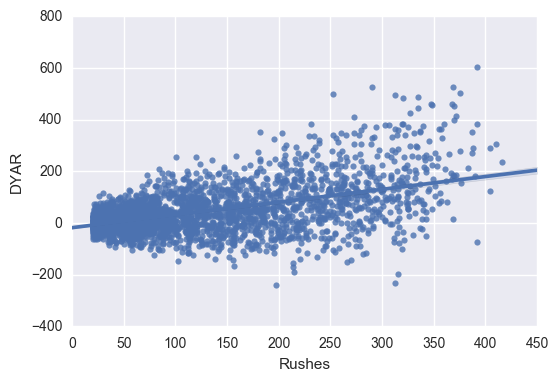

In [116]:
#DYAR compared to rushes
sns.regplot(rb_stats['Rushes'],rb_stats['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

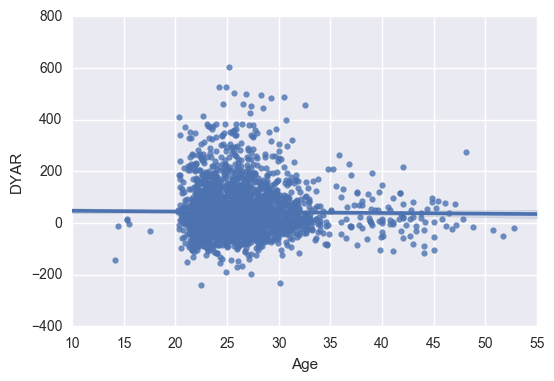

In [117]:
#Regression of age and DYAR
plt.figure(1)
sns.regplot(rb_stats['Age'],rb_stats['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

In [118]:
#rb DYAR over time
rb_career_data = rb_stats[~pd.isnull(rb_stats['DYAR_t+1'])]
rb_career_data['DYAR_diff'] = rb_career_data['DYAR'] - rb_career_data['DYAR_t-1']
rb_age_means = rb_career_data.groupby(pd.cut(rb_career_data['Age'],np.arange(22,35,1))).mean()

#qb DYAR over time
qb_career_data = qb_stats[~pd.isnull(qb_stats['DYAR_t+1'])]
qb_career_data['DYAR_diff'] = qb_career_data['DYAR'] - qb_career_data['DYAR_t-1']
qb_age_means = qb_career_data.groupby(pd.cut(qb_career_data['Age'],np.arange(22,35,1))).mean()

#wr DYAR over time
wr_career_data = wr_stats[~pd.isnull(wr_stats['DYAR_t+1'])]
wr_career_data['DYAR_diff'] = wr_career_data['DYAR'] - wr_career_data['DYAR_t-1']
wr_age_means = wr_career_data.groupby(pd.cut(wr_career_data['Age'],np.arange(22,35,1))).mean()

#te DYAR over time
te_career_data = te_stats[~pd.isnull(te_stats['DYAR_t+1'])]
te_career_data['DYAR_diff'] = te_career_data['DYAR'] - te_career_data['DYAR_t-1']
te_age_means = te_career_data.groupby(pd.cut(te_career_data['Age'],np.arange(22,35,1))).mean()


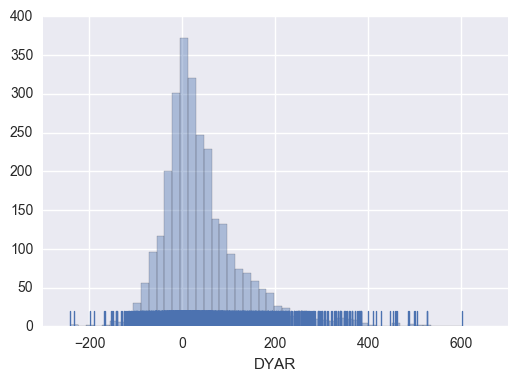

In [119]:
# distritbution of DYAR
plt.figure(1)
x = rb_stats['DYAR']
sns.distplot(x, kde=False, rug=True);
plt.show()

## Aging Curves

In [120]:
#Constructing aging curve with Delta Model

def delta_model(position):
    '''Delta Model: Take difference of DYAR between players who played consecutive years,
    then divide by midpoint of Rushes, Passes, etc. to get difference between years. Exclude all players' 
    last year to avoid  survivorship bias
    Takes in position group as parameter, returns Series with aging curve penalty for year t to t+1'''
    
    if position == "RB":
        df = rb_stats
        df = df[~pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Rushes'] + df['Rushes_t+1'])/2)
    elif position == "QB":
        df = qb_stats
        df = df[~pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Passes'] + df['Passes_t+1'])/2)
    elif position == "WR":
        df = wr_stats
        df = df[~pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Passes_To'] + df['Passes_To_t+1'])/2)
    elif position == "TE":
        df = te_stats
        df = df[~pd.isnull(df['DYAR_t+1'])]
        df['DYAR_diff'] = (df['DYAR_t+1'] - df['DYAR']) / ((df['Passes_To'] + df['Passes_To_t+1'])/2)    
    
    aging_penalties = df.groupby(pd.cut(df['Age'],np.arange(22,35,1))).mean()['DYAR_diff']
    return aging_penalties

In [121]:
# Graph of RB,QB,WR,TE Aging curve from year t to year t+1
rb_age = delta_model("RB")
qb_age = delta_model("QB")
wr_age = delta_model("WR")
te_age = delta_model("TE")

lst = []
for age in rb_age.index.values:
    lst.append(float(age[5:7]))
rb_pens = pd.DataFrame({"Age":lst,"Penalty":rb_age.values})

lst = []
for age in qb_age.index.values:
    lst.append(float(age[5:7]))
qb_pens = pd.DataFrame({"Age":lst,"Penalty":qb_age.values})

lst = []
for age in wr_age.index.values:
    lst.append(float(age[5:7]))
wr_pens = pd.DataFrame({"Age":lst,"Penalty":wr_age.values})

lst = []
for age in te_age.index.values:
    lst.append(float(age[5:7]))
te_pens = pd.DataFrame({"Age":lst,"Penalty":te_age.values})

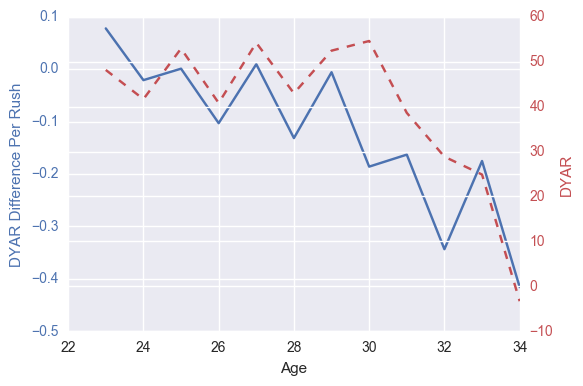

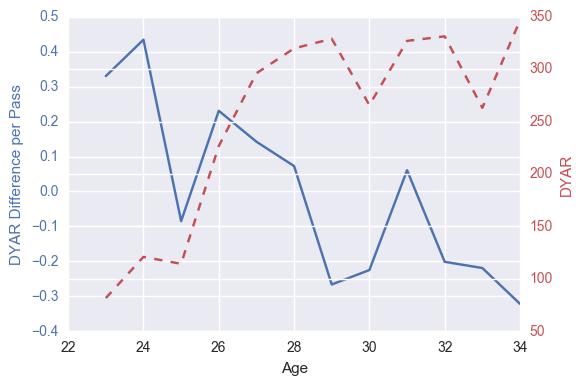

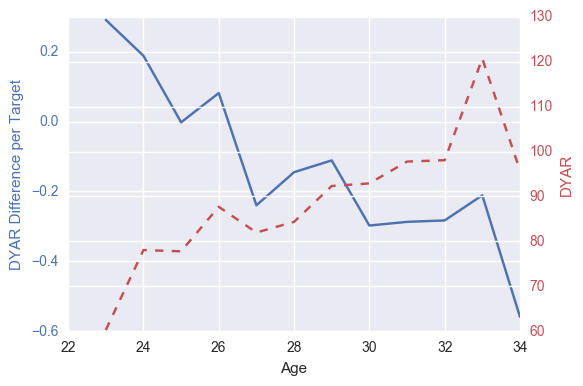

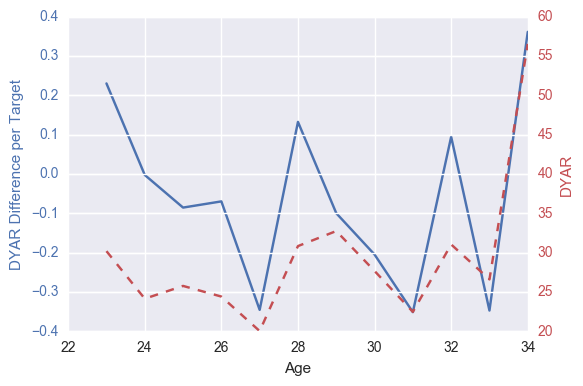

In [122]:
#RB DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(rb_pens['Age'], rb_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference Per Rush', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(rb_pens['Age'], rb_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

#QB DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(qb_pens['Age'], qb_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Pass', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(qb_pens['Age'], qb_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
#WR DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(wr_pens['Age'], wr_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Target', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(wr_pens['Age'], wr_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
#TE DYAR diff and DYAR by age
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(te_pens['Age'], te_pens['Penalty'], 'b-')
ax1.set_xlabel('Age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('DYAR Difference per Target', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(te_pens['Age'], te_age_means['DYAR_t+1'].values, 'r--')
ax2.set_ylabel('DYAR', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

Graphs Above: On the left Y-Axis is the change in DYAR per Rush/Pass/Target from the year before. On the right is the average DYAR in that year

## Marcel Model

## Regression Analysis For Season Weights

In [155]:
# Creating Regression Model(s) to get season weights
# Model 1 predicts DYAR in year t based off of DYAR in years t-1,t-2,t-3
# Model 2 predicts DYAR in year t based off of DYAR in years t-1,t-2

import statsmodels.api as sm


def get_weights_touches(position):
    touches = ''
    threshold = 0
    if position == "rb":
        df = rb_stats
        touches = "Rushes"
        threshold = 50
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        threshold = 100
    elif position == "wr":
        df = wr_stats
        touches = "Passes_To"
        threshold = 50
    elif position == "te":
        df = te_stats
        touches = "Passes_To"
        threshold = 50
        
    #Get weights for touches
    stats_mod = df[(~pd.isnull(df['{}_t-1'.format(touches)])) & (~pd.isnull(df['{}_t-2'.format(touches)])) & (~pd.isnull(df['{}_t-3'.format(touches)])) & (df[touches] > threshold)]
    stats_mod_2 = df[(~pd.isnull(df['{}_t-1'.format(touches)])) & (~pd.isnull(df['{}_t-2'.format(touches)])) & (df[touches] > threshold)]
    X  = stats_mod[['{}_t-1'.format(touches), '{}_t-2'.format(touches), '{}_t-3'.format(touches)]]
    X_2 = stats_mod_2[['{}_t-1'.format(touches), '{}_t-2'.format(touches)]]
    y = stats_mod[touches]
    y_2 = stats_mod_2[touches]

    model_1 = sm.OLS(y,X).fit()
    model_2 = sm.OLS(y_2,X_2).fit()
    
    touches3 = list(model_1.params)
    touches2 = list(model_2.params)
    
    return touches3,touches2

def get_regression_weights(position,stat):
    touches = ''
    threshold = 0
    if position == "rb":
        df = rb_stats
        touches = "Rushes"
        threshold = 50
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
        threshold = 100
    elif position == "wr":
        df = wr_stats
        touches = "Passes_To"
        threshold = 50
    elif position == "te":
        df = te_stats
        touches = "Passes_To"
        threshold = 50
        
    stats_mod = df[(~pd.isnull(df['{}_t-1'.format(stat)])) & (~pd.isnull(df['{}_t-2'.format(stat)])) & (~pd.isnull(df['{}_t-3'.format(stat)])) & (df[touches] > threshold)]
    stats_mod_2 = df[(~pd.isnull(df['{}_t-1'.format(stat)])) & (~pd.isnull(df['{}_t-2'.format(stat)])) & (df[touches] > threshold)]
    X  = stats_mod[['{}_t-1'.format(stat), '{}_t-2'.format(stat), '{}_t-3'.format(stat)]]
    X_2 = stats_mod_2[['{}_t-1'.format(stat), '{}_t-2'.format(stat)]]
    y = stats_mod[stat]
    y_2 = stats_mod_2[stat]

    model_1 = sm.OLS(y,X).fit()
    model_2 = sm.OLS(y_2,X_2).fit()
    
    stat3 = list(model_1.params)
    stat2 = list(model_2.params)
    
    return stat3,stat2

## Two Year Projections

In [129]:
def get_two_year_projections(position,stat,stat_coef,touches_coef):
    touches = ''
    if position == "rb":
        df = rb_stats
        touches = "Rushes"
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
    elif position == "wr":
        df = wr_stats
        touches = "Passes_To"
    elif position == "te":
        df = te_stats
        touches = "Passes_To"

    ## Get weighted totals
    df['Weighted_{}_2'.format(stat)] = (df['{}_t-1'.format(stat)] * stat_coef[0] +  df['{}_t-2'.format(stat)] * stat_coef[1])
    df['Weighted_{}_2'.format(touches)] = df['{}_t-1'.format(touches)] * touches_coef[0] +  df['{}_t-2'.format(touches)] * touches_coef[1]

    #Get Running Backs with 2 years of data available
    df_2 = df[(~pd.isnull(df['Weighted_{}_2'.format(stat)])) & (~pd.isnull(df['Weighted_{}_2'.format(touches)]))]

    ## Get estimate for stat at league average rate
    df_2['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)] * stat_coef[0] +  df['A{}_t-2'.format(stat)] * stat_coef[1]
    df_2['AW{}'.format(touches)] = df['{}_t-1'.format(touches)] * stat_coef[0] +  df['{}_t-2'.format(touches)] * stat_coef[1]
    ## Regress Weighted stat to Expected stat
    ## how much weighted stats should be regressed to mean
    regression_pct = df_2['Weighted_{}_2'.format(stat)].sum() / df_2[stat].sum()
    avg_rushes  = df_2[touches].mean()
    regression_touches = (1-regression_pct) / regression_pct * avg_rushes
    df_2['Reg_{}'.format(stat)] = df_2['AW{}'.format(stat)] * regression_touches / df_2['AW{}'.format(touches)]

    #Compute Expected yards
    df_2['E{}/Touch'.format(stat)] = (df_2['Reg_{}'.format(stat)] + df['Weighted_{}_2'.format(stat)]) / (regression_touches + df_2['AW{}'.format(touches)])
    df_2['E{}'.format(stat)] = df_2['E{}/Touch'.format(stat)]  * df_2['Weighted_{}_2'.format(touches)] 

    # Adding aging curve
    df_2["Age"] = np.floor(df_2['Age'])
    df_2 = df_2.merge(rb_pens, on = 'Age')
    df_2['E{}'.format(stat)] = df_2['E{}'.format(stat)] * (1 + df_2['Penalty'])
    
    return df_2

## Three Year Projections

In [130]:
def get_three_year_projections(position,stat,stat_coef,touches_coef):
    touches = ''
    if position == "rb":
        df = rb_stats
        touches = "Rushes"
    elif position == "qb":
        df = qb_stats
        touches = "Passes"
    elif position == "wr":
        df = wr_stats
        touches = "Passes_To"
    elif position == "te":
        df = te_stats
        touches = "Passes_To"

    ## Get weighted totals
    df['Weighted_{}_3'.format(stat)] = df['{}_t-1'.format(stat)] * stat_coef[0] +  df['{}_t-2'.format(stat)] * stat_coef[1] +  df['{}_t-3'.format(stat)] * stat_coef[2]
    df['Weighted_{}_3'.format(touches)] = df['{}_t-1'.format(touches)] * touches_coef[0] +  df['{}_t-2'.format(touches)] * touches_coef[1] +  df['{}_t-3'.format(touches)] * touches_coef[2]

    #Get Running Backs with 2 years of data available
    df_3 = df[(~pd.isnull(df['Weighted_{}_3'.format(stat)])) & (~pd.isnull(df['Weighted_{}_3'.format(touches)]))]

    ## Get estimate for stat at league average rate
    df_3['AW{}'.format(stat)] = df['A{}_t-1'.format(stat)] * stat_coef[0] +  df['A{}_t-2'.format(stat)] * stat_coef[1] +  df['A{}_t-3'.format(stat)] * stat_coef[2]
    df_3['AW{}'.format(touches)] = df['{}_t-1'.format(touches)] * stat_coef[0] +  df['{}_t-2'.format(touches)] * stat_coef[1] +  df['{}_t-3'.format(touches)] * stat_coef[2]
    ## Regress Weighted stat to Expected stat
    ## how much weighted stats should be regressed to mean
    regression_pct = df_3['Weighted_{}_3'.format(stat)].sum() / df_3[stat].sum()
    avg_touches  = df_3[touches].mean()
    regression_touches = (1-regression_pct) / regression_pct * avg_touches
    df_3['Reg_{}'.format(stat)] = df_3['AW{}'.format(stat)] * regression_touches / df_3['AW{}'.format(touches)]

    #Compute Expected yards
    df_3['E{}/Touch'.format(stat)] = (df_3['Reg_{}'.format(stat)] + df['Weighted_{}_3'.format(stat)]) / (regression_touches + df_3['AW{}'.format(touches)])
    df_3['E{}'.format(stat)] = df_3['E{}/Touch'.format(stat)]  * df_3['Weighted_{}_3'.format(touches)] 

    # Adding aging curve
    df_3["Age"] = np.floor(df_3['Age'])
    df_3 = df_3.merge(rb_pens, on = 'Age')
    df_3['E{}'.format(stat)] = df_3['E{}'.format(stat)] * (1 + df_3['Penalty'])
    
    return df_3

## Results - Comparing Last Year's DYAR correlation vs. Models

In [157]:
rb_rushes_coefs3,rb_rushes_coefs2 = get_weights_touches('rb')
rb_dyar_coefs3,rb_dyar_coefs2 = get_regression_weights('rb','DYAR')

qb_passes_coefs3,qb_passes_coefs2 = get_weights_touches('qb')
qb_dyar_coefs3,qb_dyar_coefs2 = get_regression_weights('qb','DYAR')

wr_targets_coefs3,wr_targets_coefs2 = get_weights_touches('wr')
wr_dyar_coefs3,wr_dyar_coefs2 = get_regression_weights('wr','DYAR')

te_targets_coefs3,te_targets_coefs2 = get_weights_touches('te')
te_dyar_coefs3,te_dyar_coefs2 = get_regression_weights('te','DYAR')

rb_stats_2 = get_two_year_projections('rb','DYAR',rb_dyar_coefs2,rb_rushes_coefs2)
qb_stats_2 = get_two_year_projections('qb','DYAR',qb_dyar_coefs2,qb_passes_coefs2)
wr_stats_2 = get_two_year_projections('wr','DYAR',qb_dyar_coefs2,wr_targets_coefs2)
te_stats_2 = get_two_year_projections('te','DYAR',qb_dyar_coefs2,te_targets_coefs2)

rb_stats_3 = get_three_year_projections('rb','DYAR',rb_dyar_coefs3,rb_rushes_coefs3)
qb_stats_3 = get_three_year_projections('qb','DYAR',qb_dyar_coefs3,qb_passes_coefs3)
wr_stats_3 = get_three_year_projections('wr','DYAR',wr_dyar_coefs3,wr_targets_coefs3)
te_stats_3 = get_three_year_projections('te','DYAR',te_dyar_coefs3,te_targets_coefs3)

In [158]:
print( "QB Projections: ")
print("COMPARING TO LAST YEAR\n",qb_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("TWO YEARS\n",qb_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",qb_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "RB Projections: ")
print("COMPARING TO LAST YEAR\n",rb_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("TWO YEARS\n",rb_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",rb_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "WR Projections: ")
print("COMPARING TO LAST YEAR\n",wr_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("TWO YEARS\n",wr_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",wr_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

print( "TE Projections: ")
print("COMPARING TO LAST YEAR\n",te_stats[['DYAR','DYAR_t-1']].corr()['DYAR'][1])
print("TWO YEARS\n",te_stats_2[['DYAR','EDYAR']].corr()['EDYAR'][0])
print("THREE YEARS\n",te_stats_3[['DYAR','EDYAR']].corr()['EDYAR'][0])
print()

QB Projections: 
COMPARING TO LAST YEAR
 0.542816101024
TWO YEARS
 0.613497087733
THREE YEARS
 0.608414721071

RB Projections: 
COMPARING TO LAST YEAR
 0.331691089619
TWO YEARS
 0.371453286805
THREE YEARS
 0.379452420876

WR Projections: 
COMPARING TO LAST YEAR
 0.376985056593
TWO YEARS
 0.422792333183
THREE YEARS
 0.43536943722

TE Projections: 
COMPARING TO LAST YEAR
 0.402914390539
TWO YEARS
 0.464311540541
THREE YEARS
 0.519517016939

